In [ ]:
# Import Tensorflow 2.0
!pip install tensorflow==2.0
import tensorflow as tf 

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

In [2]:

base_dir = "preprocessed_data"

In [197]:
# Concatenate all piano events into one long list of events
piano_joined = []
for i in range(100,200):
    recording = np.load("./preprocessed_data/recording" + str(i) + ".npy", allow_pickle=True)
    instruments = np.load("./preprocessed_data/instruments" + str(i) + ".npy", allow_pickle=True)
    for j, instrument in enumerate(instruments):
        if instrument == 0:
            initial_pause = True
            for event in recording[j]:
                if event != 387: #remove initial pauses
                    initial_pause = False
                if initial_pause == False:
                    piano_joined.append(event)

In [198]:
piano_joined = np.asarray(piano_joined)
piano_joined.shape


(497609,)

In [199]:
max(piano_joined)

387

In [200]:
# get_batch: get random continuous segments of messages from vectorized_songs
# ARGUMENTS
# vectorized_songs: the sequence to pull from
# seq_length: length of the segmen to return
# batch_size: number of segments to return
# RETURN: two numpy arrays:
# x_batch: BxL, contains segments
# y_batch: BxL. y_batch[b, l] contains the message that comes after
# x_batch[b, l]
def get_batch(vectorized_songs, seq_length, batch_size):
    n = vectorized_songs.shape[0] - 1
    idx = np.random.choice(n-seq_length, batch_size)

    input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
    output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]
    x_batch = np.reshape(input_batch, [batch_size, seq_length])
    y_batch = np.reshape(output_batch, [batch_size, seq_length])
    return x_batch, y_batch

In [123]:
x_batch, y_batch = get_batch(violin_joined, seq_length=5, batch_size=1)

In [201]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
    # Layer 2: LSTM with `rnn_units` number of units.
    LSTM(rnn_units), 
    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [177]:
model = build_model(max(piano_joined)+1, embedding_dim=256, rnn_units=1024, batch_size=32)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (32, None, 256)           99328     
_________________________________________________________________
lstm_8 (LSTM)                (32, None, 1024)          5246976   
_________________________________________________________________
dense_8 (Dense)              (32, None, 388)           397700    
Total params: 5,744,004
Trainable params: 5,744,004
Non-trainable params: 0
_________________________________________________________________


In [126]:
x, y = get_batch(violin_joined, seq_length=200, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 388) # (batch_size, sequence_length, vocab_size)


In [127]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([294,  75, 316, 128,  60, 262,  41,  68, 269, 124,  32,  56,  90,
       292, 337, 379,   7, 260, 163,  11, 148, 149, 353,  34,   1, 278,
       208, 169, 329, 240, 150, 132, 344, 267, 251,  63, 110,   9, 352,
        25, 265, 268, 224, 221, 342, 187, 275, 108,   9, 387, 240,  34,
       134, 365,  31, 333, 153,  94, 335, 102,  53, 129,  86, 167,  53,
       317,   9, 103, 333, 306, 302, 198,  82,  75, 309, 376,  81, 237,
       152, 346,  43, 168, 151, 100, 179,  29,  38, 343, 114, 254, 299,
       159,  92, 220, 193,  84,  52, 251, 231, 266])

In [202]:
def compute_loss(labels, logits):
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return loss
example_batch_loss = compute_loss(y, pred)

In [129]:
print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 388)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       5.9605346


In [216]:
# Optimization parameters:
num_training_iterations = 4000  # Increase this to train longer
batch_size = 16  # Experiment between 1 and 64
seq_length = 200  # Experiment between 50 and 500
learning_rate = 1e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = 388
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_lstm_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [214]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate)


@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    #feed the current input into the model and generate predictions'''
    y_hat = model(x)
    #compute the loss!
    loss = compute_loss(y, y_hat)
    
    #compute the gradients 
    grads = tape.gradient(loss, model.trainable_variables)
  
  # Apply the gradients to the optimizer so it can update the model accordingly
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

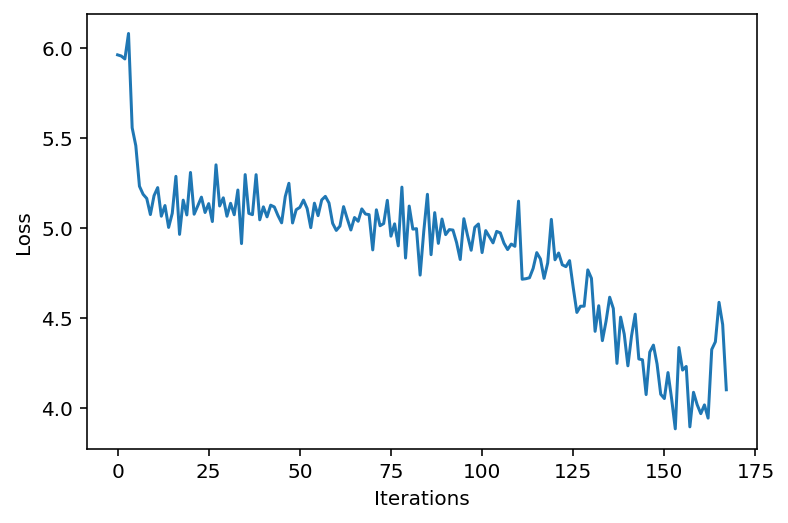

  4%|▍         | 168/4000 [10:45<4:04:23,  3.83s/it]

In [ ]:

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(piano_joined, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

In [217]:
'''TODO: Rebuild the model using a batch_size=1'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1) # TODO
# model = build_model('''TODO''', '''TODO''', '''TODO''', batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (1, None, 256)            99328     
_________________________________________________________________
lstm_15 (LSTM)               (1, None, 1024)           5246976   
_________________________________________________________________
dense_15 (Dense)             (1, None, 388)            397700    
Total params: 5,744,004
Trainable params: 5,744,004
Non-trainable params: 0
_________________________________________________________________


In [226]:
### Prediction of a generated song ###

def generate_event(model, start_event, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  input_eval = tf.expand_dims(start_event, 0)

  # Empty string to store our results
  event_generated = start_event[:]

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      #evaluate the inputs and generate the next character predictions
      predictions = model(input_eval)
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      #use a multinomial distribution to sample
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      #add the predicted character to the generated text!
      event_generated.append(predicted_id)
    
  return event_generated

In [233]:
generated_event = generate_event(model, start_event=[16,60, 340, 188, 64, 340, 192, 67, 340, 195,64, 340, 192, 60, 340, 188], generation_length=1000)

100%|██████████| 1000/1000 [00:11<00:00, 88.93it/s]


In [234]:
generated_event
np.save('generated_recording.npy', generated_event)

In [ ]:
generated_event